<a href="https://colab.research.google.com/github/gboehmwald/gab/blob/main/04_Modelo_Apalancado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Extensión

In [ ]:
pip install gurobipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 102.4 MB/s eta 0:00:00


In [ ]:
import gurobipy as gp
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

## Datos de Entrada

Los siguientes datos de entrada se utilizan en el modelo:

- $S$: conjunto de acciones
- $\mu$: vector de rendimientos esperados
- $\Sigma$: matriz de varianza-covarianza
    - $\sigma_{ij}$ covarianza entre los rendimientos de los activos $i$ y $j$
    - $\sigma_{ii}$ varianza del rendimiento del activo $i$

In [ ]:
# Importar datos
Sigma = pd.read_pickle("sigma.pkl")
mu = pd.read_pickle("mu.pkl")

## Formulación

El modelo maximiza el rendimiento esperado total para un nivel fijo de varianza (riesgo) preespecificado. Matemáticamente, esto resulta en un problema de optimización convexa con restricciones cuadráticas.

### Variables de Decisión y Cotas de las Variable

Las variables de decisión en el modelo son las proporciones de capital invertidas entre las acciones consideradas. El vector correspondiente de posiciones se denota por $x$, donde su componente $x_i$ representa la proporción de capital invertido en la acción $i$.

Ahora, la variable de posición no tiene cotas; modelando el apalancamiento y venta en corto.

###  Restricciones
La restricción presupuestaria garantiza que todo el capital esté invertido:

$$\sum_{i \in S} x_i =1$$

El riesgo estimado debe ser, como máximo, el nivel de varianza admisible preespecificado $\bar\sigma^2$:

$$x^\top \Sigma x \leq \bar\sigma^2$$

###  Función Objetivo
El objetivo es maximizar el rendimiento esperado del portafolio:

$$\max_x \mu^\top x $$

Usando gurobipy, esto se puede expresar de la siguiente manera:

In [ ]:
V = 35  # varianza máxima admisible (sigma^2)

# Crear un modelo de optimización vacío
m = gp.Model()

# Agregar variables: x[i] denota la proporción invertida en la acción i
x = m.addMVar(len(mu), lb=-np.inf, ub=np.inf, name="x")

# Restricción presupuestaria: todas las inversiones suman 1
m.addConstr(x.sum() == 1, name="Restriccion_Presupuesto")

# Límite en la varianza
restriccion_riesgo = m.addConstr(x @ Sigma.to_numpy() @ x <= V, name="restriccion_riesgo")

m.params.MIPGap = 0
m.params.NonConvex = 2

# Definir la función objetivo: Maximizar el rendimiento esperado
m.setObjective(mu.to_numpy() @ x, gp.GRB.MAXIMIZE)

Restricted license - for non-production use only - expires 2026-11-23
Set parameter MIPGap to value 0
Set parameter NonConvex to value 2


Resolvemos:

In [ ]:
m.optimize()

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Non-default parameters:
MIPGap  0
NonConvex  2

Optimize a model with 1 rows, 10 columns and 10 nonzeros
Model fingerprint: 0x3115202e
Model has 1 quadratic constraint
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [2e-02, 3e+02]
  Objective range  [1e+00, 4e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
  QRHS range       [4e+01, 4e+01]
Presolve time: 0.01s
Presolved: 11 rows, 21 columns, 75 nonzeros
Presolved model has 1 second-order cone constraint
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 10
 AA' NZ     : 5.500e+01
 Factor NZ  : 6.600e+01
 Factor Ops : 5.060e+02 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal 

Mostrar los datos básicos de la solución:

In [ ]:
print(f"Varianza:         {x.X @ Sigma @ x.X:.6f}")
print(f"Tiempo de solución:    {m.Runtime:.2f} segundos\n")

# Imprimir inversiones (con valores no despreciables, es decir, > 1e-6)
positions = pd.Series(name="Posición", data=x.X, index=mu.index)
print(f"Número de transacciones positivas: {positions[positions > 1e-6].count()}\n")
print(positions[positions > 1e-6])
print(f"\nNúmero de transacciones negativas: {positions[positions < -1e-6].count()}\n")
print(positions[positions < -1e-6])

Varianza:         34.999999
Tiempo de solución:    0.03 segundos

Número de transacciones positivas: 6

CALICHERAB Cierre Ix    0.180300
ENAEX Cierre Ix         0.890284
CHILE Cierre Ix         0.468500
MALLPLAZA Cierre Ix     0.025443
INDISA Cierre Ix        0.069152
HABITAT Cierre Ix       0.462974
Name: Posición, dtype: float64

Número de transacciones negativas: 4

VOLCAN Cierre Ix       -0.055931
SALFACORP Cierre Ix    -0.190112
ANTARCHILE Cierre Ix   -0.341495
SK Cierre Ix           -0.509115
Name: Posición, dtype: float64


In [ ]:
df = pd.DataFrame(
    index=mu.index,
    data={
        "x": x.X,
    },
).round(6)

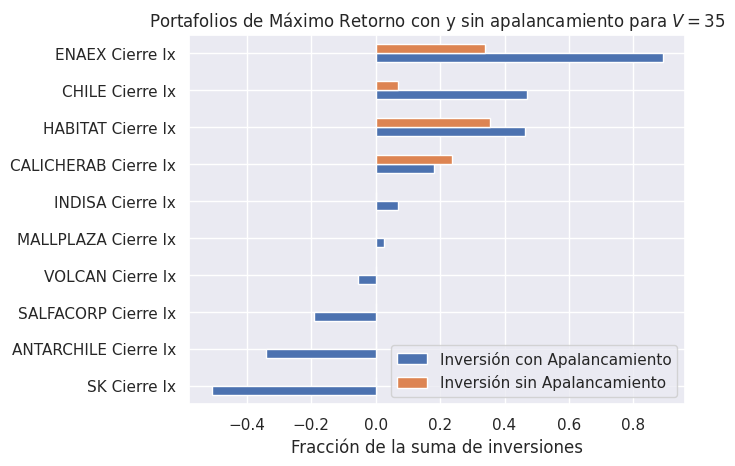

In [ ]:
# adjust RHS of short constraint
x.lb = 0
x.ub = 1
m.params.OutputFlag = 0
m.optimize()

# retrieve and display solution data
mask = (abs(df["x"]) > 1e-6) | (x.X > 1e-6)
df2 = pd.DataFrame(
    index=df["x"][mask].index,
    data={
        "Inversión con Apalancamiento": df["x"],
        "Inversión sin Apalancamiento": x.X[mask],
    },
).sort_values(by=["Inversión con Apalancamiento"], ascending=True)

axs = df2.plot.barh()
axs.set_xlabel("Fracción de la suma de inversiones")
plt.title("Portafolios de Máximo Retorno con y sin apalancamiento para $V=35$")
plt.show()